# N-band simulation of image source
This notebook is adapted from the SimMetis example notebook: https://github.com/astronomyk/SimMETIS/blob/master/notebooks/SimMETIS_simulate_image.ipynb

Each image is associated with a spectrum. The resulting `Source` object can be thought of as a cube, which is the sum of the images weighted with their associated spectrum. 

In [74]:
import numpy as np
from glob import glob
from astropy.io import fits

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

import simmetis as sim

## Setting up the source

In [205]:
cmds = sim.UserCommands('metis_image_N.config')
# cmds = sim.UserCommands("metis_image_LM.config")

model = './5noext/npix37/'
d = 100 # pc
metis_pixscale = 0.007

with fits.open(model+'image10.fits') as inhdul:
    sourceimg = inhdul[0].data[0]
    sourcehdr = inhdul[0].header

try:
    print("Pixel unit:", sourcehdr['UNITS'])
except:
    print("Pixel unit:", sourcehdr['BUNIT'])

Pixel unit: Jy / pixel


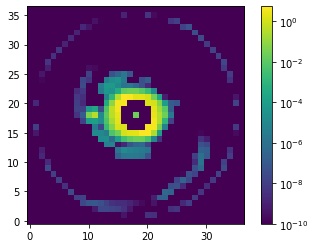

In [206]:
cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))
plt.imshow(sourceimg, cmap=cmap, norm=LogNorm(vmin=1e-10), origin='lower')
plt.colorbar()

In [207]:
# Check image pixel scale
try:
    pixscale = sourcehdr['CDELT1'] * -3600
except:
    pixscale = sourcehdr['CD1_1'] * -3600

# If image pixscale not the same as the detector pixscale, need to specify oversample to interpolate between the two scales. 
oversample = pixscale / metis_pixscale

print("Pixel scale:", pixscale, "arcsec/pixel, oversample:", oversample)

Pixel scale: 0.00702712097249436 arcsec/pixel, oversample: 1.0038744246420515


In [209]:
# Read spectrum (function from radmc3dpy)
def readSpectrum(fname):
    with open(fname, 'r') as rfile:
        # Read the format number
        dum = rfile.readline()
        # Read the number of wavelengths
        nwav = int(rfile.readline())
        # Read a blank line
        dum = rfile.readline()

        res = np.zeros([nwav, 2], dtype=np.float64)
        for iwav in range(nwav):
            dum = rfile.readline().split()
            res[iwav, 0] = float(dum[0])
            res[iwav, 1] = float(dum[1])
    return res

spectrum = readSpectrum(model+'spectrum.out')
wav = spectrum[:,0]
spec = spectrum[:,1] * 1e23 / d ** 2        # Conversion from erg s-1 cm-2 Hz-1 to Jy at d pc

As the image pixel values are in Jy/pixel and since SimMETIS operates internally with ph/(m2 s px bin), where bin is the spectral bin width, we need to calculate the conversion factor between the two. Here we compute the number of photons/(m2 s um) that correspond to 1 Jy at $\lambda_{\mathrm{ref}}$.
The input $flux$\[ph/(m2 s bin)\] = $spec$\[Jy\] $\times \ \ f_{\lambda}$\[ph/(m2 s um)/Jy\] $\times \ \ dlam$\[um/bin\] 

In [210]:
from astropy import units as u
lam_ref = 10 * u.um
flam_ref = (1 * u.Jy).to(u.ph * u.s**-1 * u.m**-2 * u.um**-1, 
                         equivalencies=u.spectral_density(lam_ref))
print("1 Jy at {0:5.2f} corresponds to {1:5.2f}".format(lam_ref, flam_ref))

# SimMETIS expects the spectral flux density to be given in units of photons / (m2 s px bin):
dlam = np.zeros(len(wav)-1)  # [um], spectral bin width
for i in range(len(wav)-1):
    dlam[i] = wav[i+1] - wav[i]
#flux = spec[:-1] * flam_ref.value * dlam
#lam = wav[:-1]

flux = spec[90:110] * flam_ref.value * dlam[90:110]
lam = wav[90:110]

1 Jy at 10.00 um corresponds to 1509190.18 ph / (m2 s um)


We can now construct the SimMETIS `Source` object using the function `sim.source.source_from_image`. The `oversample` parameter is necessary to prevent aliasing due to the way that images are currently handled in SimMETIS.

In [211]:
src = sim.source.source_from_image(sourceimg, lam, flux, 
                                   plate_scale=pixscale, oversample=oversample)

# Setting up and running the simulation

In [214]:
# Set filter
cmds['INST_FILTER_TC'] = 'TC_filter_N2.dat'

# Build the optical train and the detector
opttrain = sim.OpticalTrain(cmds)
fpa = sim.Detector(cmds, small_fov=True)

# Apply optical train to source object
src.apply_optical_train(opttrain, fpa)

# Read out detectors, results are FITS HDU objects
imghdu_2 = fpa.read_out(OBS_DIT=2)
imghdu_7200 = fpa.read_out(OBS_DIT=7200)

Safety switch is on - Detector(..., small_fov='True')
Generating image for chip 0
Reading out chip 0 using superfast
DIT = 2    NDIT = 1.0
Reading out chip 0 using superfast
DIT = 7200    NDIT = 1.0


## Looking at the results

pixel scale is 6.78999999999996 mas/pix


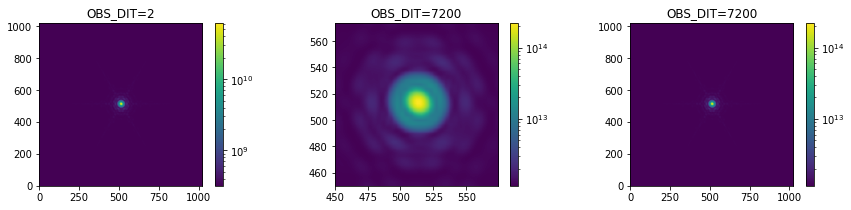

In [215]:
#extent = (xmin, xmax, ymin, ymax) = (300, 724, 300, 724)
extent = (xmin, xmax, ymin, ymax) = (450, 574, 450, 574)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

im1 = ax1.imshow(imghdu_2[0].data,
           norm=LogNorm(), origin='lower')
ax1.set_title("OBS_DIT=2")
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(imghdu_7200[0].data[xmin:xmax,ymin:ymax], extent=extent,
          norm=LogNorm(), origin='lower')
ax2.set_title("OBS_DIT=7200")
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(imghdu_7200[0].data,
           norm=LogNorm(), origin='lower')
ax3.set_title("OBS_DIT=7200")
fig.colorbar(im3, ax=ax3)
print('pixel scale is', imghdu_2[0].header['CDELT1'] * 3600 * 1000, 'mas/pix')

In [182]:
imghdu_7200.writeto(model+"sd0615_METIS_N2_7200sec.fits", overwrite=True)

## Additional checks

(37, 37)

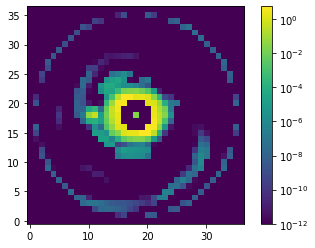

In [208]:
# plot oversampled image
import scipy.ndimage.interpolation as spi
newimg = spi.zoom(sourceimg, oversample, order=3)
plt.imshow(newimg, origin="lower", cmap=cmap, norm=LogNorm(vmin=1e-12))
plt.colorbar()
newimg.shape

In [83]:
# List all available filters
filters = glob("../data/TC_filter*.dat")
for filter in filters:
    print(filter.split("s/")[2])